<a href="https://colab.research.google.com/github/sreesriavvaru123/MI/blob/main/PTB_XL_4_classes_v2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Colab-compatible notebook for MI detection using PTB-XL with 12-leads and 10-fold CV



## STEP 1: Install necessary packages



In [1]:
!pip install wfdb scikit-learn matplotlib tensorflow --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 113.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.1 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.


## STEP 2: Import required libraries


In [2]:
import os
import numpy as np
import pandas as pd
import wfdb
import ast
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

## STEP 3: Load metadata and diagnostic class mapping

In [3]:
def load_ptbxl_metadata(path):
    data = pd.read_csv(os.path.join(path, 'ptbxl_database.csv'))
    data.scp_codes = data.scp_codes.apply(lambda x: ast.literal_eval(x))
    return data

# Load SCP statements
def load_diagnostic_class_mapping(path):
    return pd.read_csv(os.path.join(path, 'scp_statements.csv'), index_col=0)

## STEP 4: Apply MI vs Non-MI filter

In [12]:
def apply_diagnostic_filter_4class(data, class_map, filter_only_4classes=True):
    """
    Maps SCP codes to diagnostic classes and assigns one of 4 diagnostic labels:
    'MI', 'NORM', 'STTC', or 'Other'.

    Parameters:
    - data: DataFrame containing 'scp_codes'
    - class_map: DataFrame with SCP code -> diagnostic_class mapping
    - filter_only_4classes: if True, drops records not assigned one of the 4 main labels

    Returns:
    - DataFrame with added columns: 'diagnostic_class' (list), 'diagnostic_label' (string)
    """
    # Step 1: Map SCP codes to diagnostic classes
    data['diagnostic_class'] = data.scp_codes.apply(
        lambda x: list(set([class_map.loc[k].diagnostic_class for k in x if k in class_map.index]))
    )

    # Step 2: Assign a label based on priority
    priority_list = ['MI', 'NORM', 'STTC']

    def assign_label(class_list):
        for cls in priority_list:
            if cls in class_list:
                return cls
        return 'Other'

    data['diagnostic_label'] = data.diagnostic_class.apply(assign_label)

    # Step 3: Optionally filter for 4 main classes
    if filter_only_4classes:
        data = data[data['diagnostic_label'].isin(priority_list + ['Other'])].copy()

    return data




## STEP 5: Load ECG signals

In [5]:
def load_raw_data(df, sampling_rate, path):
    data = []
    for i in range(len(df)):
        record_name = df.iloc[i].filename_lr if sampling_rate == 100 else df.iloc[i].filename_hr
        record_path = os.path.join(path, record_name)
        signal, _ = wfdb.rdsamp(record_path)
        data.append(signal)
    return np.array(data)

## STEP 6: Define ResNet-like model

In [13]:
def build_model(input_shape):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=7, activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(128, kernel_size=5, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(256, kernel_size=3, activation='relu', padding='same'))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))
    return model

## STEP 7: Main pipeline

In [7]:
from google.colab import files
files.upload()  # Upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"avvarusrinivasulu","key":"fe47c5051ef67f1130ff6e2e1fa439be"}'}

In [8]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Install kaggle CLI if not already
!pip install -q kaggle

# Download the PTB-XL dataset
!kaggle datasets download -d khyeh0719/ptb-xl-dataset

# Unzip the dataset
!unzip ptb-xl-dataset.zip -d ptb-xl


Streaming output truncated to the last 5000 lines.
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19338_hr.hea  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19339_hr.dat  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19339_hr.hea  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19340_hr.dat  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19340_hr.hea  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19341_hr.dat  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19341_hr.hea  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/1934

In [14]:
ptbxl_path = '/content/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1'

# Step 1: Load metadata and SCP map
df = load_ptbxl_metadata(ptbxl_path)
scp_map = load_diagnostic_class_mapping(ptbxl_path)
scp_map = scp_map[scp_map.diagnostic_class.notnull()]

# Step 2: Extract diagnostic classes
df['diagnostic_superclass'] = df.scp_codes.apply(
    lambda x: list(set([scp_map.loc[k].diagnostic_class for k in x if k in scp_map.index]))
)

# Step 3: Assign single label using priority
priority_classes = ['MI', 'STTC', 'NORM']
def assign_diagnostic_label(class_list):
    for cls in priority_classes:
        if cls in class_list:
            return cls
    return 'Other'

df['diagnostic_label'] = df.diagnostic_superclass.apply(assign_diagnostic_label)

# Step 4: Keep only 4 classes (MI, STTC, NORM, Other)
final_classes = ['MI', 'STTC', 'NORM', 'Other']
df_filtered = df[df['diagnostic_label'].isin(final_classes)].copy()

# Step 5: Load ECG signals
X = load_raw_data(df_filtered, sampling_rate=100, path=ptbxl_path)

# Step 6: Normalize ECG signals
X = (X - np.mean(X)) / np.std(X)

# Step 7: Encode labels
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
y = le.fit_transform(df_filtered['diagnostic_label'])

# Optional: save class-to-index mapping
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Mapping:", label_mapping)  # e.g., {'MI': 0, 'NORM': 1, 'Other': 2, 'STTC': 3}

# Step 8: One-hot encode labels
y_cat = to_categorical(y, num_classes=4)

# Step 9: Train/Val/Test split
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_cat, test_size=0.4, random_state=42, stratify=y_cat
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)


Label Mapping: {'MI': np.int64(0), 'NORM': np.int64(1), 'Other': np.int64(2), 'STTC': np.int64(3)}


## Model setup and Training

In [17]:
# Model setup
model = build_model(X_train.shape[1:])
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[checkpoint, early_stopping])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5760 - loss: 1.0545

410/410 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.5761 - loss: 1.0543 - val_accuracy: 0.6851 - val_loss: 0.7875
Epoch 2/100
407/410 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6795 - loss: 0.8277

410/410 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.6795 - loss: 0.8277 - val_accuracy: 0.7090 - val_loss: 0.7351
Epoch 3/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7070 - loss: 0.7690 - val_accuracy: 0.6952 - val_loss: 0.7414
Epoch 4/100
407/410 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7289 - loss: 0.7324

410/410 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7289 - loss: 0.7323 - val_accuracy: 0.7582 - val_loss: 0.6376
Epoch 5/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7428 - loss: 0.6975 - val_accuracy: 0.7568 - val_loss: 0.6313
Epoch 6/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7475 - loss: 0.6766

410/410 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7475 - loss: 0.6766 - val_accuracy: 0.7813 - val_loss: 0.5924
Epoch 7/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7586 - loss: 0.6365 - val_accuracy: 0.7511 - val_loss: 0.6543
Epoch 8/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7662 - loss: 0.6269 - val_accuracy: 0.7531 - val_loss: 0.6630
Epoch 9/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7755 - loss: 0.6077 - val_accuracy: 0.7289 - val_loss: 0.6882
Epoch 10/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7788 - loss: 0.6005 - val_accuracy: 0.7793 - val_loss: 0.5925
Epoch 11/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7744 - loss: 0.5985

410/410 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7745 - loss: 0.5985 - val_accuracy: 0.7820 - val_loss: 0.5974
Epoch 12/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7840 - loss: 0.5794 - val_accuracy: 0.7655 - val_loss: 0.5864
Epoch 13/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7893 - loss: 0.5618 - val_accuracy: 0.7708 - val_loss: 0.6170
Epoch 14/100
409/410 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7846 - loss: 0.5742

410/410 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7846 - loss: 0.5742 - val_accuracy: 0.7973 - val_loss: 0.5794
Epoch 15/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7965 - loss: 0.5439 - val_accuracy: 0.7806 - val_loss: 0.5950
Epoch 16/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7992 - loss: 0.5493 - val_accuracy: 0.7731 - val_loss: 0.6158
Epoch 17/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7987 - loss: 0.5408 - val_accuracy: 0.7909 - val_loss: 0.5949
Epoch 18/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8024 - loss: 0.5192 - val_accuracy: 0.7774 - val_loss: 0.6071
Epoch 19/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8066 - loss: 0.5251 - val_accuracy: 0.7767 - val_loss: 0.7273
Epoch 20/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8036 - loss: 0.5293 - val_accuracy: 0.7864 - val_loss: 0.6518
Epoch 21/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8116 - loss: 0.5058 - val_a

## Testing the Model

In [18]:
# Evaluate on test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Confusion Matrix and Classification Report
print("Classification Report:")
print(classification_report(y_true_labels, y_pred_labels))

print("Confusion Matrix:")
print(confusion_matrix(y_true_labels, y_pred_labels))

# Save final model
model.save("mi_detection_resnet_model_v12.0.h5")

137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.74      0.76      1097
           1       0.84      0.92      0.87      1899
           2       0.72      0.57      0.64       591
           3       0.69      0.70      0.70       781

    accuracy                           0.79      4368
   macro avg       0.76      0.73      0.74      4368
weighted avg       0.78      0.79      0.78      4368

Confusion Matrix:
[[ 809  102   60  126]
 [  48 1739   39   73]
 [  69  138  335   49]
 [ 101  101   29  550]]


## Tetsing on PTB database

In [ ]:
# STEP 1: Install dependencies
!pip install wfdb scikit-learn numpy matplotlib

import os
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib  # or from tensorflow.keras.models import load_model if deep learning

# STEP 2: Download PTB Database (use PhysioNet mirror)
# !wget -r -N -c -np https://physionet.org/static/published-projects/ptbdb/ptb-diagnostic-ecg-database-1.0.0/ -P ptb_data
# STEP 2: Download via WFDB API
wfdb.dl_database('ptbdb', dl_dir='ptb_data')



Generating record list for: patient001/s0010_re
Generating record list for: patient001/s0014lre
Generating record list for: patient001/s0016lre
Generating record list for: patient002/s0015lre
Generating record list for: patient003/s0017lre
Generating record list for: patient004/s0020are
Generating record list for: patient004/s0020bre
Generating record list for: patient005/s0021are
Generating record list for: patient005/s0021bre
Generating record list for: patient005/s0025lre
Generating record list for: patient005/s0031lre
Generating record list for: patient005/s0101lre
Generating record list for: patient006/s0022lre
Generating record list for: patient006/s0027lre
Generating record list for: patient006/s0064lre
Generating record list for: patient007/s0026lre
Generating record list for: patient007/s0029lre
Generating record list for: patient007/s0038lre
Generating record list for: patient007/s0078lre
Generating record list for: patient008/s0028lre
Generating record list for: patient008/s

In [ ]:
# import os

# for root, dirs, files in os.walk("ptb_data"):
#     for name in files:
#         if name.endswith(".hea"):
#             print(os.path.join(root, name))

# STEP 3: Collect 12-lead .hea files
import glob
import wfdb

record_paths = sorted(glob.glob("ptb_data/patient*/**/*.hea", recursive=True))
print("Found", len(record_paths), "records")

Found 549 records


In [ ]:
# STEP 4: Define helpers for reading, resampling, segmenting


def read_12lead_ecg(path):
    rec = wfdb.rdrecord(path[:-4])
    # picks 12 standard leads, ignoring Frank leads
    data = rec.p_signal[:, :12].T  # (12, n_samples)
    return data, rec

def resample_to_100Hz(arr, orig=1000, target=100):
    num = int(arr.shape[1] * target / orig)
    return resample(arr, num, axis=1)

def normalize(x): return (x - x.mean()) / x.std()


In [ ]:
# STEP 5: Build test dataset
X_test, y_test = [], []

for p in record_paths:
    data, rec = read_12lead_ecg(p)
    r100 = resample_to_100Hz(data)
    seg = r100[:, :1000]  # 10 sec @ 100 Hz
    seg = normalize(seg)
    # Label extraction
    c = " ".join(rec.comments).lower()
    if "myocardial infarction" in c:
        y = 1
    elif "healthy" in c:
        y = 0
    else:
        continue
    X_test.append(seg); y_test.append(y)

X_test = np.array(X_test)  # (n,12,1000)
y_test = np.array(y_test)
print("Test data shape:", X_test.shape, "| Labels:", y_test.shape)



Test data shape: (448, 12, 1000) | Labels: (448,)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
Shape of y_pred_prob: (448, 2)
Classification Report:

              precision    recall  f1-score   support

      Normal       0.28      0.78      0.41        80
          MI       0.92      0.57      0.70       368

    accuracy                           0.60       448
   macro avg       0.60      0.67      0.56       448
weighted avg       0.81      0.60      0.65       448



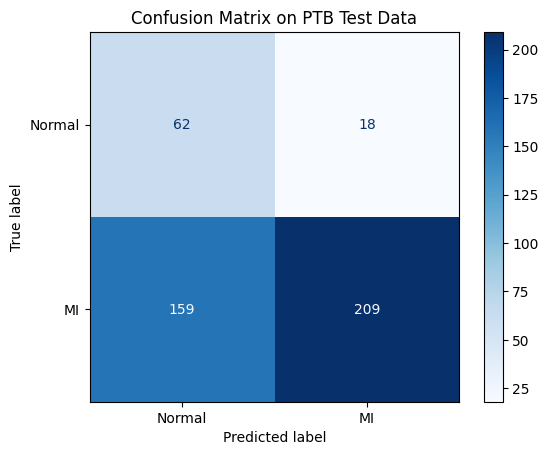

In [ ]:
# STEP 6: Reshape if needed and load your trained model
# Example for sklearn or Keras model
# Reshape if your model needs (samples, features)

from tensorflow.keras.models import load_model

# Load model — adjust path as needed
# model = joblib.load("your_mi_model.pkl")  # Replace with your model path
model = load_model("mi_detection_resnet_model_v1.1.h5") # For Keras:

# STEP 7: Predict and evaluate
# Convert shape (N, 12, 1000) → (N, 1000, 12)
X_keras = np.transpose(X_test, (0, 2, 1))  # Time-first format

# Predict
y_pred_prob = model.predict(X_keras)

# If binary classification:
y_pred = np.argmax(y_pred_prob, axis=1)
print("Shape of y_pred_prob:", y_pred_prob.shape)
# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Normal", "MI"]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "MI"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix on PTB Test Data")
plt.show()



In [ ]:
!zip -r /content/ptb_data.zip /content/ptb_data

  adding: content/ptb_data/ (stored 0%)
  adding: content/ptb_data/patient038/ (stored 0%)
  adding: content/ptb_data/patient038/s0125lre.xyz (deflated 29%)
  adding: content/ptb_data/patient038/s0162lre.xyz (deflated 30%)
  adding: content/ptb_data/patient038/s0128lre.dat (deflated 26%)
  adding: content/ptb_data/patient038/s0162lre.hea (deflated 63%)
  adding: content/ptb_data/patient038/s0128lre.xyz (deflated 31%)
  adding: content/ptb_data/patient038/s0125lre.dat (deflated 23%)
  adding: content/ptb_data/patient038/s0162lre.dat (deflated 24%)
  adding: content/ptb_data/patient038/s0125lre.hea (deflated 63%)
  adding: content/ptb_data/patient038/s0128lre.hea (deflated 63%)
  adding: content/ptb_data/patient281/ (stored 0%)
  adding: content/ptb_data/patient281/s0537_re.hea (deflated 68%)
  adding: content/ptb_data/patient281/s0537_re.dat (deflated 25%)
  adding: content/ptb_data/patient281/s0537_re.xyz (deflated 29%)
  adding: content/ptb_data/patient029/ (stored 0%)
  adding: conte

## STEP 8: 5-Fold Cross-Validation

In [ ]:
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# fold = 1
# histories, reports = [], []

# for train_index, test_index in skf.split(X, y):
#     print(f"\n--- Fold {fold} ---")
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

#     model = build_resnet_model(X.shape[1:])
#     model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
#     early_stop = EarlyStopping(patience=5, restore_best_weights=True)

#     history = model.fit(X_train, y_train, epochs=30, batch_size=32,
#                         validation_split=0.2, callbacks=[early_stop], verbose=0)
#     histories.append(history)

#     y_pred = (model.predict(X_test) > 0.5).astype(int)
#     print(classification_report(y_test, y_pred))
#     cm = confusion_matrix(y_test, y_pred)
#     ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-MI', 'MI']).plot()
#     plt.title(f"Fold {fold} Confusion Matrix")
#     plt.show()
#     reports.append(classification_report(y_test, y_pred, output_dict=True))

#     # Save model from one fold for future testing
#     if fold == 1:
#         model.save('/content/mi_detector_resnet_fold1.h5')

#     fold += 1